In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
import tensorflow_datasets as tfds

In [3]:
# Getting data

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(train_ds, test_ds), metadata = tfds.load('cats_vs_dogs', split=['train[:35%]', 'train[90%:95%]'],
                                          with_info=True, as_supervised=True, shuffle_files=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.DDKWJO_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

In [6]:
total_train_img = train_ds.__len__().numpy()
print(f"X Train size: {total_train_img}")

total_test_img = test_ds.__len__().numpy()
print(f"X Test size: {total_test_img}")

X Train size: 8142
X Test size: 1163


In [7]:
im_iter = train_ds.__iter__()

(345, 309, 3)
<dtype: 'uint8'>


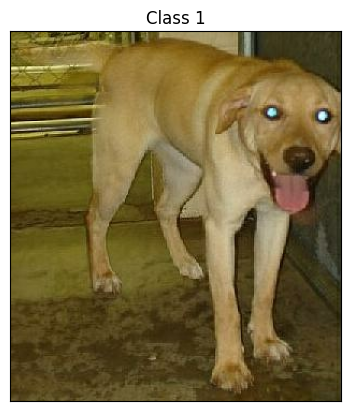

In [30]:
# Demo

image, label = next(im_iter)
plt.imshow(image.numpy())
print(image.numpy().shape)
print(image.dtype)
plt.title(f"Class {label.numpy()}")
plt.xticks([])
plt.yticks([])
plt.show()

# Class 0 = cats, Class 1 = dogs

In [27]:
# Format image to resnet standards

def image_formatting(image, label):
  image = tf.image.resize(image, (224, 224))
  image = tf.cast(image, tf.float32)
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  return image, label


In [28]:
train = train_ds.map(image_formatting)
test = test_ds.map(image_formatting)

In [26]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [29]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [31]:
# Freeze weights in layer 0, or base_model
model.layers[0].trainable = False

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
batch_size = 128
shuffle_size = 1000


## This loads 1000 imgs onto ram, then 128 imgs onto vram(GPU)
# This speeds up the data pipeline significantly
# This way, the GPU doesn't have to load data from the ssd/hdd every time

train_batches = train.shuffle(shuffle_size).batch(batch_size)
test_batches = test.batch(batch_size)

In [35]:
history = model.fit(train_batches, validation_data=test_batches, epochs=5)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9471 - loss: 0.1299 - val_accuracy: 0.9880 - val_loss: 0.0425
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 882ms/step - accuracy: 0.9950 - loss: 0.0144 - val_accuracy: 0.9888 - val_loss: 0.0362
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 866ms/step - accuracy: 0.9969 - loss: 0.0097 - val_accuracy: 0.9880 - val_loss: 0.0418
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 810ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.9871 - val_loss: 0.0389
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 818ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9914 - val_loss: 0.0376


In [37]:
pred_itr = test.take(100).__iter__()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


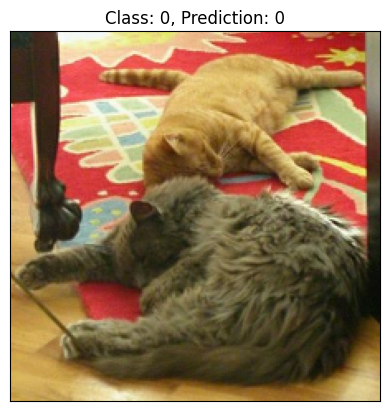

In [66]:
image, label = next(pred_itr)

img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = np.expand_dims(img_array, axis=0)

predicted_class = int((model.predict(img_array) > 0.5).item())
plotting_img = (image.numpy() + 1) / 2

plt.imshow(plotting_img)
plt.title(f"Class: {label.numpy()}, Prediction: {predicted_class}")
plt.xticks([])
plt.yticks([])
plt.show()